In [1]:
import pandas as pd
import pyspark.sql.functions
# Reading CSV file with tweets / users (escaping \r\n with multiLine and escape options)
tweets = sqlContext.read.format('com.databricks.spark.csv')\
.options(header='true', inferschema='true', encoding='UTF-8', parserLib='univocity',  multiLine='true', escape='\"')\
.load('/Users/brugge/Documents/lu/lda/tweets.csv')
tweets.registerTempTable("tweets")
users = sqlContext.read.format('com.databricks.spark.csv')\
.options(header='true', inferschema='true', parserLib='univocity',  multiLine='true', escape='\"')\
.load('/Users/brugge/Documents/lu/lda/users.csv')
users.registerTempTable("users")

In [2]:
#print("Tweets Schema")
tweets.printSchema()
#print("Users Schema")
users.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- user_key: string (nullable = true)
 |-- created_at: long (nullable = true)
 |-- created_str: timestamp (nullable = true)
 |-- retweet_count: integer (nullable = true)
 |-- retweeted: boolean (nullable = true)
 |-- favorite_count: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- source: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- expanded_urls: string (nullable = true)
 |-- posted: string (nullable = true)
 |-- mentions: string (nullable = true)
 |-- retweeted_status_id: long (nullable = true)
 |-- in_reply_to_status_id: long (nullable = true)

root
 |-- id: long (nullable = true)
 |-- location: string (nullable = true)
 |-- name: string (nullable = true)
 |-- followers_count: integer (nullable = true)
 |-- statuses_count: integer (nullable = true)
 |-- time_zone: string (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- lang: string (nullable = t

In [3]:
# export of tweets csv with data quality count
sqlContext.sql("select count(user_id) from tweets").show()
tweets.na.drop(subset='user_id').count()

+--------------+
|count(user_id)|
+--------------+
|        195386|
+--------------+



195386

In [4]:
# export of users csv with data quality 
sqlContext.sql("select count(distinct id) from users").show()
users.na.drop(subset='id').distinct().count()

+------------------+
|count(DISTINCT id)|
+------------------+
|               392|
+------------------+



392

In [5]:
# Tweets count per months + null
from pyspark.sql.functions import month, count
tweets2 = tweets
tweets2.groupBy(month('created_str').alias("month"))\
    .agg(count('user_id').alias("sum"))\
    .orderBy('month')\
    .show()

+-----+-----+
|month|  sum|
+-----+-----+
| null|   21|
|    1|23890|
|    2|16391|
|    3|13641|
|    4| 6715|
|    5| 4005|
|    6| 3237|
|    7|12337|
|    8|13814|
|    9|25947|
|   10|28951|
|   11|22978|
|   12|23459|
+-----+-----+



In [6]:
tweets.orderBy(tweets.created_at.desc())\
.select('user_key', 'text', 'created_str')\
.first()

Row(user_key='manuelkrosss', text='Pal�stinenser erschie�t Israelis � Attent�ter tot https://t.co/F4aO6rgWWV', created_str=datetime.datetime(2017, 9, 26, 9, 5, 32))

In [7]:
tweets.na.drop(subset='created_at')\
.orderBy(tweets.created_at.asc())\
.select('user_key', 'text', 'created_at').first()

Row(user_key='evagreen69', text='I am in Love with LOVE!', created_at=1405361095000)

In [8]:
tweets = tweets.join(users, tweets.user_id == users.id, 'inner')

In [9]:
# Grouped by UserId and 20 rows fetched in descending order
mostTweets = tweets.groupBy(users.id).count().orderBy('count', ascending = False).show(20)

+----------+-----+
|        id|count|
+----------+-----+
|1679279490| 9269|
|1671234620| 6813|
|2882013788| 6652|
|2671070290| 4140|
|4508630900| 3663|
|1727482238| 3346|
|1768259989| 3263|
|1868496344| 3261|
|2572058134| 3229|
|1658420976| 3215|
|1655194147| 3212|
|1658202894| 3201|
|1623180199| 3197|
|1684524144| 3197|
|4224729994| 3194|
|1676481360| 3192|
|1660771422| 3188|
|1694026190| 3169|
|1649967228| 3159|
|1680366068| 3156|
+----------+-----+
only showing top 20 rows



In [10]:
import requests, re
from pyspark.sql import Row
from collections import Counter

# used for unshortening URL, but faced exception ;/
def unshorten_url(url):
    try:
        r = requests.Session().head(url, allow_redirects=True).url
        return r
    except e:
        return e
# search for URL inside of tweet text with re library and regex defined
regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]&(?:%[0-9a-fA-F][0-9a-fA-F]))+'
def get_url(url):
    return re.findall(regex, url)

# Select tweets text and search
s = tweets.select('text').rdd.flatMap(lambda x: get_url(x[0]))
urls = sc.parallelize(s.take(2000))
urls.map(Row("URL")).toDF()\
.filter('length(URL) > 19')\
.groupBy('URL').count()\
.orderBy('count', ascending = False)\
.show()
# .select(lambda x: unshorten_url(x))\  
# To transform to correct URL by func defined above - unshorten_url

+--------------------+-----+
|                 URL|count|
+--------------------+-----+
|https://t.co/rRZg...|    6|
|https://t.co/aXQa...|    6|
|https://t.co/telX...|    4|
|https://t.co/3d02...|    2|
|https://t.co/RZbn...|    2|
|https://t.co/S9bv...|    2|
|https://t.co/cdnQ...|    2|
|https://t.co/1KPX...|    2|
|https://t.co/HivQ...|    2|
|https://t.co/8bMd...|    2|
|https://t.co/eMX9...|    2|
|https://t.co/iChL...|    2|
|https://t.co/1jS4...|    2|
|https://t.co/G6IF...|    1|
|https://t.co/jXBm...|    1|
|https://t.co/TZsD...|    1|
|https://t.co/biG1...|    1|
|https://t.co/lEHn...|    1|
|https://t.co/wXM0...|    1|
|https://t.co/6hyg...|    1|
+--------------------+-----+
only showing top 20 rows



In [11]:
# All hashtags list per count in the tweets
pip = pyspark.sql.functions.split(tweets['hashtags'], ',')
tweets.filter(tweets.hashtags != '[]')\
.withColumn('hashtags', pip)\
.groupBy('hashtags')\
.count()\
.select('hashtags', 'count')\
.orderBy('count', ascending=False)\
.show(20)

+--------------------+-----+
|            hashtags|count|
+--------------------+-----+
|      [["Politics"]]| 3097|
|          [["news"]]| 1319|
|          [["tcot"]]|  971|
|[["MerkelMussBlei...|  791|
|[["RejectedDebate...|  614|
|         [["Trump"]]|  546|
|[["ThingsYouCantI...|  526|
|[["SurvivalGuideT...|  518|
|          [["maga"]]|  517|
|[["IdRunForPresid...|  494|
|[["ThingsMoreTrus...|  492|
|[["BetterAlternat...|  492|
|[["ChristmasAfter...|  491|
|    [["nowplaying"]]|  478|
|    [["IslamKills"]]|  476|
|[["IHaveARightToK...|  475|
|[["RuinADinnerInO...|  469|
|[["RealLifeMagicS...|  469|
|[["GiftIdeasForPo...|  459|
|         [["pjnet"]]|  450|
+--------------------+-----+
only showing top 20 rows



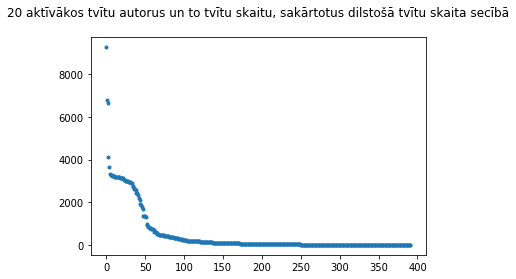

In [12]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# For drawing :)
matplotlib.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots()
ax.plot(tweets.groupBy(users.id).count().orderBy('count', ascending = False).select('count').collect(), '.')
ax.set_title('20 aktīvākos tvītu autorus un to tvītu skaitu, sakārtotus dilstošā tvītu skaita secībā\n')
plt.show()

In [14]:
# Tweet hashtags per month
from pyspark.sql.functions import month, count
tweets2 = tweets
tweets2.groupBy(month('created_str').alias("month"), 'hashtags')\
    .agg(tweets2.hashtags)\
    .orderBy('month', ascending=False)\
    .show(20)

+-----+--------------------+--------------------+
|month|            hashtags|            hashtags|
+-----+--------------------+--------------------+
|   12|["StandUpForScien...|["StandUpForScien...|
|   12|       ["Democrats"]|       ["Democrats"]|
|   12|["BernieWouldHave...|["BernieWouldHave...|
|   12|        ["ReduceDC"]|        ["ReduceDC"]|
|   12|         ["poverty"]|         ["poverty"]|
|   12|        ["cemetery"]|        ["cemetery"]|
|   12|        ["BlackLiv"]|        ["BlackLiv"]|
|   12|      ["EnforceLaw"]|      ["EnforceLaw"]|
|   12|       ["TamirRice"]|       ["TamirRice"]|
|   12|    ["cabinetpicks"]|    ["cabinetpicks"]|
|   12|        ["ArticleV"]|        ["ArticleV"]|
|   12|          ["health"]|          ["health"]|
|   12|   ["neckillusions"]|   ["neckillusions"]|
|   12|          ["Itunes"]|          ["Itunes"]|
|   12|    ["HacksawRidge"]|    ["HacksawRidge"]|
|   12|            ["Sell"]|            ["Sell"]|
|   12|       ["MediaBias"]|       ["MediaBias"]|
